In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Iterable
from scipy import optimize, stats, signal

In [2]:
class AcidBasePartition:
    
    def __init__(self, pKa):
        self.pKa = np.array(pKa)
        
    @property
    def Ka(self):
        return self.pinv(self.pKa)
    
    @property
    def n(self):
        return len(self.pKa)
    
    @staticmethod
    def p(x):
        return -np.log10(x)
    
    @staticmethod
    def pinv(x):
        return np.power(10., -x)
    
    def monom(self, i, pH):
        return np.power(self.pinv(pH), i) * np.prod(self.Ka[:(self.n - i)])
    
    def polynom(self, pH):
        return np.sum([self.monom(i, pH) for i in range(self.n + 1)], axis=0)
    
    def polynom_coefficients(self):
        return [np.prod(self.Ka[:i]) for i in range(self.n + 1)]
    
    def polynom_roots(self):
        return np.roots(self.polynom_coefficients())
    
    #def polynom(self, pH):
    #    return np.poly1d(self.polynom_coefficients())(self.pinv(pH))
    
    def alpha(self, i, pH):
        return self.monom(i, pH) / self.polynom(pH)
    
    def alphas(self, pH):
        
        a = np.array([
            self.alpha(self.n - i, pH)
            for i in range(self.n + 1)
        ]).T
    
        if not np.allclose(np.sum(a.T, axis=0), 1.):
            raise ValueError("Partition functions does not sum up to unity")        
        
        return a
    
    def equilibrium_system(self, C, Ct, Na):
        return np.array([
            # Acid/Base Equilibria:
            (C[i + 1] * C[-1]) - C[i] * self.Ka[i]
            for i in range(self.n)
        ] + [
            # Charge Balance:
            np.sum(np.arange(self.n + 1) * C[:-1]) - Na,
            # Mass Balance:
            np.sum(C[:-1]) - Ct
        ])
    
    def equilibrium(self, C):
        
        Ct = np.sum(C[:-1])
        Na = np.sum(np.arange(self.n + 1) * C[:-1])
        
        sol, info, code, message = optimize.fsolve(
            self.equilibrium_system,
            x0=[1.] * (self.n + 2),
            args=(Ct, Na),
            full_output=True,
        )
        
        if code != 1:
            raise ValueError("Solution not found: %s" % message)
            
        check = self.equilibrium_system(sol, Ct, Na)
        if not np.allclose(check, 0.):
            raise ValueError("Roots not enough small: %s" % check)
        
        return sol
    
    def titration_system(self, pH1, pH0, nb, Ct, Vt):
        
        a0 = self.alphas(pH0)
        a1 = self.alphas(pH1)
        
        da = a1 - a0
        dC = da * Ct
        dn = dC * Vt
        
        if not np.isclose(np.sum(dn), 0.):
            raise ValueError("Mass balance not respected %s" % dn)
        
        nb0 = -np.sum(dn[dn<0])
        
        return np.array([
            nb0 - nb
        ])
    
    def titration(self, C0, V0, Cb, resolution=500, factor=1.0):
        
        C = self.equilibrium(C0)
        Ct = np.sum(C[:-1])
        
        nH = np.sum(np.arange(self.n + 1) * C[:-1][::-1]) * V0
        Vbt = nH / Cb
        Vb = np.linspace(0, Vbt * factor, resolution)
        nb = Vb * Cb
        Vt = V0 + Vb
 
        dnb = np.diff(nb)[0]
        
        pH = np.full(Vb.shape, np.nan)
        pH[0] = self.p(C[-1])
        
        for i, V in enumerate(Vt):
            if i > 0:
                pH[i] = optimize.fsolve(self.titration_system, x0=[pH[i - 1]], args=(pH[i - 1], dnb, Ct, V))[0]
                
        return Vb, pH
        
    
    def plot(self, pHmin=0, pHmax=14, resolution=500):
        
        pH = np.linspace(pHmin, pHmax, resolution)
        alphas = self.alphas(pH)
        
        fig, axe = plt.subplots()
        axe.plot(pH, alphas)
        
        axe.set_title("Acid/Base Partitions pKa=%s" % self.pKa)
        axe.set_xlabel(r"Proton concentration, $pH$ [-]")
        axe.set_ylabel(r"Partition Functions, $\alpha_i$ [-]")
        axe.legend([r"$\alpha_{%d}$" % i for i in reversed(range(self.n + 1))])
        axe.grid()
        
        return axe
    
    def plot_solution(self, C, axe=None):
        
        if axe is None:
            axe = self.plot()
        
        pH = self.p(C[-1])
        alphas = C[:-1] / np.sum(C[:-1])
        
        axe.axvline(pH, linestyle="--", color="black")
        axe.scatter([pH] * (self.n + 1), alphas, color="black")
        
        return axe
        
    
    def plot_monoms(self, pHmin=0, pHmax=14, resolution=500):
        
        pH = np.linspace(pHmin, pHmax, resolution)
        D = solver.polynom(pH)
        
        fig, axe = plt.subplots()
        for i in reversed(range(solver.n + 1)):
            axe.semilogy(pH, solver.monom(i, pH), label=r"$N_{%d}$" % i)
        axe.semilogy(pH, D, "--", color="black", linewidth=3, label="$D = \sum N_i$")
        
        axe.set_title("Partition monoms")
        axe.set_xlabel("Proton concentration, $pH$ [-]")
        axe.set_ylabel("Monoms, $N_i(pH)$ [-]")
        axe.legend()
        axe.grid()
    
        return axe
    
    def plot_validity(self, pHmin=0, pHmax=14, resolution=500):
        
        pH = np.linspace(pHmin, pHmax, resolution)
        C0 = []
        for x in pH:
            a0 = solver.alphas(x)
            try:
                C0.append(solver.equilibrium(list(a0) + [1e-7]))
            except:
                C0.append([np.nan] * (solver.n + 2))
        C0 = np.array(C0)
        
        fig, axe = plt.subplots()
        axe.plot(pH, pH, label="Baseline")
        axe.plot(pH, -np.log10(C0[:,-1]), label="Estimation")
        
        axe.set_title("Solution agreement")
        axe.set_xlabel("Proton concentration, $pH$ [-]")
        axe.set_ylabel("Proton concentration, $pH$ [-]")
        axe.legend()
        axe.grid()
    
        return axe

In [3]:
solver = AcidBasePartition([2.0, 2.7, 6.16, 10.26])
solver = AcidBasePartition([4.75, 8.65])

In [4]:
pH = np.linspace(0, 14, 100)

In [5]:
solver.polynom_coefficients()

[1.0, 1.778279410038923e-05, 3.9810717055349693e-14]

In [6]:
solver.polynom_roots()

array([-1.77805551e-05, -2.23900305e-09])

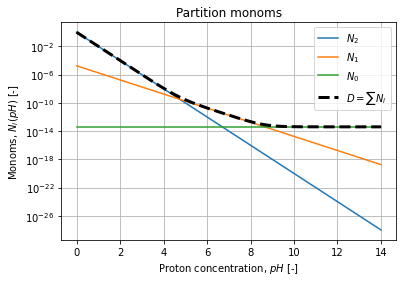

In [7]:
axe = solver.plot_monoms()

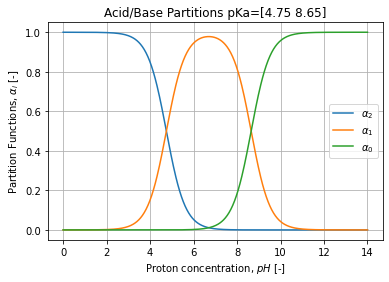

In [8]:
axe = solver.plot()

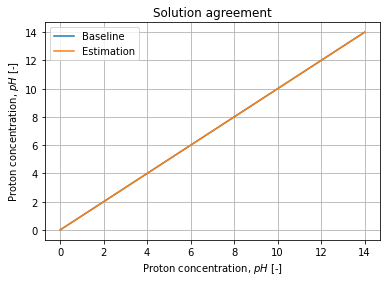

In [9]:
axe = solver.plot_validity()

In [10]:
Vb, pH = solver.titration([2.0, 0.0001, 0.0, 1e-7], 0.1, 5.25, factor=1.4)

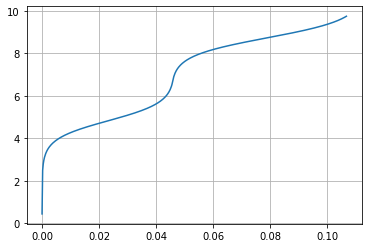

In [11]:
fig, axe = plt.subplots()
axe.plot(Vb, pH)
axe.grid()

In [12]:
C0 = list(solver.alphas(pH[0])) + [solver.pinv(pH[0])]
C1 = list(solver.alphas(pH[-1])) + [solver.pinv(pH[-1])]

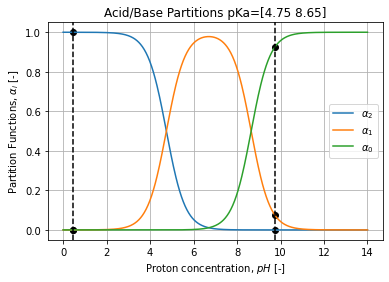

In [13]:
axe = solver.plot_solution(C0)
axe = solver.plot_solution(C1, axe=axe)